In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm
from sklearn.linear_model import lars_path,enet_path
import scipy.special as sp
from scipy.optimize import brentq
from tqdm.notebook import tqdm
import time
from joblib import Parallel, delayed    # Parallel processing

In [6]:
# import mean and covariance matrix of the 100 assets and 3 factors
mu = pd.read_csv('mean.csv',header=None)
S = pd.read_csv('var.csv',header=None)
mu = mu.drop(0,axis=1)
S = S.drop(0,axis=1)
mu = np.asarray(mu).flatten()
S = np.asarray(S)

In [7]:
# Set parameters for the optimization problem
sigma = 0.04   # target standard deviation
N = 103        # number of assets 
K = 3          # number of factors
T = 240        # number of time series observations
Kfold = 10     # number of folds for cross-validation
nobs = 100     # number of simulations

#### Function to compute adjusted squared Sharpe ratio (Eq.1.32)

In [8]:
def theta_adj(theta,N,T):
    a = N/2
    b = (T-N)/2
    theta_a = ((T-N-2)*theta-N)/T+2*theta**a*(1+theta)**(-(T-2)/2)/T/(sp.betainc(a,b,theta/(1+theta))*sp.beta(a,b))
    return theta_a

#### function to obtain the optimal weights under the MAXSER rule, we use lars_path in this function.
#### Here is the documentation of lars_path:  [lars_path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lars_path.html)
Note that the objective function of lars_path is
$\frac{1}{2n}\sum_{i=1}^n (y_i-x_i'\beta)^2+\alpha \sum_{j=1}^p|\beta_j|$

In [9]:
# Input: r: TxN matrix of excess returns
#        sigma: target standard deviation
#        Kfold: number of folds
# Output: w: optimal weights based on the MAXSER rule
#
def MAXSER(r,sigma,Kfold):
    T,N = r.shape
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    theta = np.dot(muh,inv(Sh).dot(muh))
    theta_a = theta_adj(theta,N,T)
    rc = (1+theta_a)/np.sqrt(theta_a)*sigma
    zeta = np.zeros(Kfold)
    T1 = np.fix(T/Kfold).astype(int)
    y1 = rc*np.ones(T-T1)
    for i in range(Kfold):
        ind = range(i*T1,(i+1)*T1)
        r1 = np.delete(r,ind,axis=0)
        _, _, b1 = lars_path(r1,y1,method='lasso')
        q = np.std(np.matmul(r[ind,:],b1),axis=0,ddof=1)
        j = np.argmin(np.abs(sigma-q))
        zeta[i] = norm(b1[:,j],1)/norm(b1[:,-1],1)
    zeta = np.mean(zeta)
    y = rc*np.ones(T)
    _, _, b = lars_path(r,y,method='lasso')
    zeta0 = norm(b,1,axis=0)/norm(b[:,-1],1)
    ind = np.min(np.argwhere(zeta0>zeta))
    q = (zeta-zeta0[ind-1])/(zeta0[ind]-zeta0[ind-1])
    w = (1-q)*b[:,ind-1]+q*b[:,ind]
    return w

#### function to obtain the optimal weights under the MAXSER with factors rule

In [10]:
# Input: r: TxN matrix of excess returns
#        f: TxK matrix of factors
#        sigma: target standard deviation
#        Kfold: number of folds
# Output: w: optimal weights based on the MAXSER rule
#
def MAXSERf(r,f,sigma,Kfold):
    T,N = r.shape
    T,K = f.shape
    Y = np.concatenate((r,f),axis=1)
    muh = np.mean(Y,axis=0)
    Sh = np.cov(Y,rowvar=False,ddof=0)
    theta = np.dot(muh,inv(Sh).dot(muh))
    theta_a = theta_adj(theta,N+K,T)
    muf = muh[N:]
    Sf = Sh[N:,N:]
    theta_f = np.dot(muf,inv(Sf).dot(muf))
    theta_u = theta_a-theta_f
#   When \theta_u<=0, just invest in the factors    
    if theta_u<=0:
        w = np.concatenate((np.zeros((N,1)),sigma/np.sqrt(theta_f)*inv(Sf).dot(muf)))
        return w
    bb = np.matmul(inv(Sf),Sh[N:,:N])         # betas
    U = r-np.matmul(f,bb)                     # TxN matrix of r_t-\beta*f_t
    wf = sigma/np.sqrt(theta_a)*inv(Sf).dot(muf)   # 1st term of \hat{w}_f in (1.30)
    ff = np.reshape(f.dot(wf),(T,1))
    xhat = sigma*np.sqrt(theta_u/theta_a)
    rc = (1+theta_u)/np.sqrt(theta_u)         # rc based on the definition in (1.26)
    zeta = np.zeros(Kfold)
    T1 = np.fix(T/Kfold).astype(int)
    y1 = rc*np.ones(T-T1)
#   Use K-fold cross-validation to find the optimal zeta    
    for i in range(Kfold):
        ind = range(i*T1,(i+1)*T1)
        U1 = np.delete(U,ind,axis=0)
        _, _, b1 = lars_path(U1,y1,method='lasso')        
#   Out-of-sample portfolio returns for different values of b1        
        x = ff[ind]+xhat*np.matmul(U[ind,:],b1)   
        q = np.std(x,axis=0,ddof=1)
        j = np.argmin(np.abs(sigma-q))
        zeta[i] = norm(b1[:,j],1)/norm(b1[:,-1],1)
    zeta = np.mean(zeta)
    y = rc*np.ones(T)
    _, _, b = lars_path(U,y,method='lasso')
    zeta0 = norm(b,1,axis=0)/norm(b[:,-1],1)
    ind = np.min(np.argwhere(zeta0>zeta))
    q = (zeta-zeta0[ind-1])/(zeta0[ind]-zeta0[ind-1])
    wu = xhat*((1-q)*b[:,ind-1]+q*b[:,ind])
    wf = wf-bb.dot(wu)
    w = np.concatenate((wu,wf))
    return w

#### function to obtain the optimal weights under the Ridge regression portfolio rule

In [11]:
# Input: x: value of lambda
#        r1sq: r1'*r1, where r1 is the excess returns in the training sample
#        r2: excess returns in the validation sample
# Output: difference between the out-of-sample standard deviation and the target standard deviation
#
def os_std(x,r1sq,r2,ry1):
    wh = inv(r1sq+x*np.eye(N)).dot(ry1)
    rh = r2.dot(wh)
    return np.std(rh,ddof=1)-sigma

In [12]:
# Input: r: TxN matrix of excess returns
#        sigma: target standard deviation
#        Kfold: number of folds
# Output: w: optimal weights based on the MAXSER rule
#
def RIDGE(r,sigma,Kfold):
    T,N = r.shape
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    theta = np.dot(muh,inv(Sh).dot(muh))
    theta_a = theta_adj(theta,N,T)
    rc = (1+theta_a)/np.sqrt(theta_a)*sigma
    lam = np.zeros(Kfold)
    T1 = np.fix(T/Kfold).astype(int)
    y1 = rc*np.ones(T-T1)
    for i in range(Kfold):
        ind = range(i*T1,(i+1)*T1)
        r1 = np.delete(r,ind,axis=0)
        r2 = r[ind,:]
        r1sq = np.matmul(r1.T,r1)
        ry1 = r1.T.dot(y1)
#   Find lambda such that the out-of-sample deviation is the same as the target standard deviation   
        if os_std(0,r1sq,r2,ry1)<=0:
            lam[i] = 0
        else:
            lam[i] = brentq(os_std,0,50,args=(r1sq,r2,ry1))
    lam = np.mean(lam)   
    y = rc*np.ones(T)
    w = inv(np.matmul(r.T,r)+lam*np.eye(N)).dot(r.T.dot(y))
    return w.flatten()

#### Function to simulate returns and compute the out-of-sample standard deviation and Sharpe ratio for different portfolio rules

In [13]:
def Simulation():
    r = np.random.multivariate_normal(mu,S,T)
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    wh = np.dot(inv(Sh),muh)
    wh = sigma/np.sqrt(np.dot(wh,muh))*wh
    os_ps = np.sqrt(np.dot(wh,S.dot(wh)))
    os_psr = np.sqrt(12)*np.dot(wh,mu)/os_ps
    wm = MAXSER(r,sigma,Kfold)
    os_ms= np.sqrt(np.dot(wm,S.dot(wm)))
    os_msr = np.sqrt(12)*np.dot(wm,mu)/os_ms
    wmf = MAXSERf(r[:,:-K],r[:,-K:],sigma,Kfold)
    os_mfs = np.sqrt(np.dot(wmf,S.dot(wmf)))
    os_mfsr = np.sqrt(12)*np.dot(wmf,mu)/os_mfs
    wr = RIDGE(r,sigma,Kfold)
    os_rs = np.sqrt(np.dot(wr,S.dot(wr)))
    os_rsr = np.sqrt(12)*np.dot(wr,mu)/os_rs
    return ([os_ps,os_psr,os_ms,os_msr,os_mfs,os_mfsr,os_rs,os_rsr])

In [14]:
start_time = time.time()
os_ps,os_psr,os_ms,os_msr,os_mfs,os_mfsr,os_rs,os_rsr = zip(*(Simulation() for i in tqdm(range(nobs))))
elapsed_time = time.time()-start_time
print('Elpased Time:',time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

Elpased Time: 00:00:40


#### If we use parallel processing, we could substantially reduce the simulation time

In [16]:
start_time = time.time()
os_ps,os_psr,os_ms,os_msr,os_mfs,os_mfsr,os_rs,os_rsr = zip(*Parallel(n_jobs=-1)(delayed(Simulation)() for i in tqdm(range(nobs))))
elapsed_time = time.time()-start_time
print('Elpased Time:',time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

Elpased Time: 00:00:03


In [17]:
# Average out-of-sample standard deviation of various portfolio rules across simulations 
print(np.mean(np.vstack([os_ps, os_ms, os_mfs, os_rs]),axis=1))

[0.07069101 0.04067606 0.04266801 0.04035984]


In [18]:
# Average out-of-sample annualized Sharpe ratio of various portfolio rules across simulations
print(np.mean(np.vstack([os_psr, os_msr, os_mfsr, os_rsr]),axis=1))

[0.90033072 1.25054166 1.48162419 1.18355186]


In [19]:
# Theoretical Maximum Sharpe ratio (annualized)
sr = np.sqrt(12*np.dot(mu,inv(S).dot(mu)))
sr

1.8824247694761491

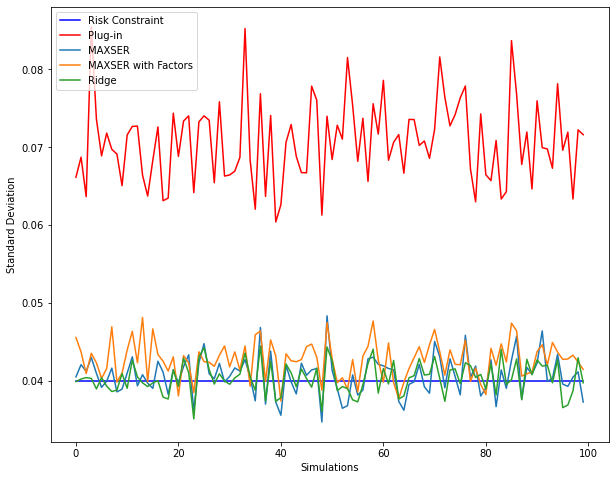

In [26]:
x = range(nobs)
y = np.ones(nobs)
plt.figure(figsize=(10,8))
plt.plot(x,y*sigma,'b-',x,os_ps,'r-',x,os_ms,x,os_mfs,x,os_rs)
plt.xlabel('Simulations')
plt.ylabel('Standard Deviation')
plt.legend(['Risk Constraint','Plug-in','MAXSER','MAXSER with Factors','Ridge'])
plt.show()

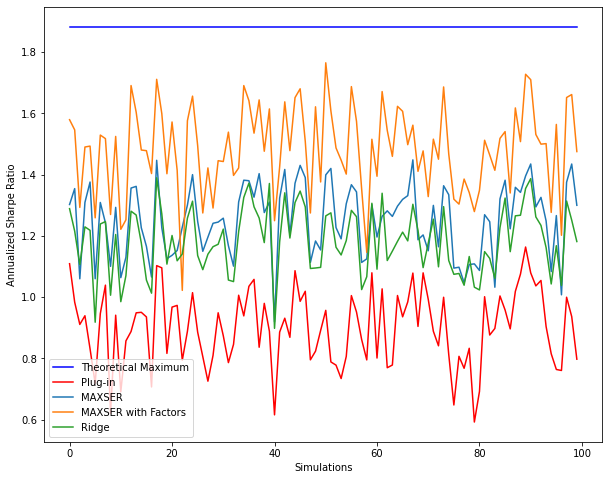

In [27]:
plt.figure(figsize=(10,8))
plt.plot(x,y*sr,'b-',x,os_psr,'r-',x,os_msr,x,os_mfsr,x,os_rsr)
plt.xlabel('Simulations')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend(['Theoretical Maximum','Plug-in','MAXSER','MAXSER with Factors','Ridge'])
plt.show()